In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
import numpy as np
import os
import librosa
import librosa.display

In [ ]:
def binarization(self, probabilities, binarization_type='global_threshold', threshold=0.5, time_axis=1):
        """Binarization
        Parameters
        ----------
        probabilities : numpy.ndarray
            Probabilities to be binarized
        binarization_type : str ('global_threshold', 'class_threshold', 'frame_max')
        threshold : float
            Binarization threshold, value of the threshold are replaced with 1 and under with 0.
            Default value 0.5
        time_axis : int
            Axis index for the frames
            Default value 1
        Raises
        ------
        AssertionError:
            Unknown binarization_type
        Returns
        -------
        numpy.ndarray
            Binarized data
        """

        if binarization_type not in ['global_threshold', 'class_threshold', 'frame_max']:
            message = '{name}: Unknown frame_binarization type [{type}].'.format(
                name=self.__class__.__name__,
                type=binarization_type
            )

            self.logger.exception(message)
            raise AssertionError(message)

        # Get data_axis
        if time_axis == 0:
            data_axis = 1
        else:
            data_axis = 0

        if binarization_type == 'global_threshold':
            return numpy.array(probabilities >= threshold, dtype=int)

        elif binarization_type == 'class_threshold' and isinstance(threshold, list):
            data = []
            for class_id, class_threshold in enumerate(threshold):
                if data_axis == 0:
                    data.append(numpy.array(probabilities[class_id, :] >= class_threshold, dtype=int))

                elif data_axis == 1:
                    data.append(numpy.array(probabilities[:, class_id] >= class_threshold, dtype=int))

            if data_axis == 0:
                return numpy.vstack(data)

            elif data_axis == 1:
                return numpy.vstack(data).T

        elif binarization_type == 'frame_max':
            if data_axis == 0:
                return numpy.array((probabilities / numpy.max(probabilities, axis=0)) == 1, dtype=int)

            elif data_axis == 1:
                return numpy.array((probabilities.T / numpy.max(probabilities, axis=1)).T == 1, dtype=int)

In [ ]:
def find_contiguous_regions(self, activity_array):
        """Find contiguous regions from bool valued numpy.array.
        Transforms boolean values for each frame into pairs of onsets and offsets.
        Parameters
        ----------
        activity_array : numpy.array [shape=(t)]
            Event activity array, bool values
        Returns
        -------
        numpy.ndarray [shape=(2, number of found changes)]
            Onset and offset indices pairs in matrix
        """

        # Find the changes in the activity_array
        change_indices = numpy.logical_xor(activity_array[1:], activity_array[:-1]).nonzero()[0]

        # Shift change_index with one, focus on frame after the change.
        change_indices += 1

        if activity_array[0]:
            # If the first element of activity_array is True add 0 at the beginning
            change_indices = numpy.r_[0, change_indices]

        if activity_array[-1]:
            # If the last element of activity_array is True, add the length of the array
            change_indices = numpy.r_[change_indices, activity_array.size]

        # Reshape the result into two columns
        return change_indices.reshape((-1, 2))

In [ ]:
def process_events(self, minimum_event_length=None, minimum_event_gap=None):
        """Process event content

        Makes sure that minimum event length and minimum event gap conditions are met per event label class.

        Parameters
        ----------
        minimum_event_length : float > 0.0
            Minimum event length in seconds, shorten than given are filtered out from the output.
            Default value None

        minimum_event_gap : float > 0.0
            Minimum allowed gap between events in seconds from same event label class.
            Default value None

        Returns
        -------
        MetaDataContainer

        """

        processed_events = []
        files = self.unique_files
        if not files:
            files = [None]

        for filename in files:

            for event_label in self.unique_event_labels:
                current_events_items = self.filter(filename=filename, event_label=event_label)

                # Sort events
                current_events_items = sorted(current_events_items, key=lambda k: k.onset)

                # 1. remove short events
                event_results_1 = []
                for event in current_events_items:
                    if minimum_event_length is not None:
                        if event.offset - event.onset >= minimum_event_length:
                            event_results_1.append(event)

                    else:
                        event_results_1.append(event)

                if len(event_results_1) and minimum_event_gap is not None:
                    # 2. remove small gaps between events
                    event_results_2 = []

                    # Load first event into event buffer
                    buffered_event_onset = event_results_1[0].onset
                    buffered_event_offset = event_results_1[0].offset
                    for i in range(1, len(event_results_1)):
                        if event_results_1[i].onset - buffered_event_offset > minimum_event_gap:
                            # The gap between current event and the buffered is bigger than minimum event gap,
                            # store event, and replace buffered event
                            current_event = copy.deepcopy(event_results_1[i])
                            current_event.onset = buffered_event_onset
                            current_event.offset = buffered_event_offset
                            event_results_2.append(current_event)

                            buffered_event_onset = event_results_1[i].onset
                            buffered_event_offset = event_results_1[i].offset

                        else:
                            # The gap between current event and the buffered is smaller than minimum event gap,
                            # extend the buffered event until the current offset
                            buffered_event_offset = event_results_1[i].offset

                    # Store last event from buffer
                    current_event = copy.copy(event_results_1[len(event_results_1) - 1])
                    current_event.onset = buffered_event_onset
                    current_event.offset = buffered_event_offset
                    event_results_2.append(current_event)

                    processed_events += event_results_2

                else:
                    processed_events += event_results_1

        return MetaDataContainer(processed_events)

In [ ]:
from tensorflow.keras.callbacks import *

In [ ]:
import keras
from keras.layers import *
from keras.models import Model
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval

In [ ]:
def readAudio(filename):
    x, sr = librosa.load(filename, sr=16000)
    return x, sr

#calculate spectrogram
def calc_spec(x):
  """Extract acoustic features (stft) for given audio file and return them."""
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann', dtype = np.complex256))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

In [ ]:
import librosa
def get_feature_matrix(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    audio, fs = librosa.load(audio_filename_path)
    hop_len = 0.02
    mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=hop_len, fs = fs)
    mel_data = mel_extractor.extract(y=audio)
    return mel_data, hop_len
        

In [ ]:
import librosa
def get_feature_matrix_script_features(audio_filename_path):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""

    audio, fs = librosa.load(audio_filename_path, sr = 16000)
    mel_data = calc_spec(audio)
    return mel_data, 10/mel_data.shape[1]

In [ ]:
def csv_to_meta_container(csv_file_path):
  """Converts CSV files to dcase util containers for easy handling of data inside CSV file"""
  dict_container = dcase_util.containers.ListDictContainer(filename = csv_file_path)
  dict_container.load()
  train_meta = dcase_util.containers.MetaDataContainer(dict_container)
  print(train_meta)
  return train_meta

In [ ]:
train_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/labels_updated.csv')

In [ ]:
X_train = []
Y_train = []
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/wav_updated'

for audio_filename in os.listdir(audio_folder_name):
    """Takes in folder of wav files, processes them to extract features, then converts and stacks them to form X_train and Y_train for the model input"""

    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)

    # Targets
    event_list = train_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data

    X_train.append(features) 
    Y_train.append(np.array(event_roll))
 

In [ ]:
import numpy as np
def load_features_and_labels(features_path, labels_path):
  """Takes in folder of wav files, processes them to extract features, then converts and stacks them to form X_train and Y_train for the model input"""
  X = np.load(features_path)
  Y = np.load(labels_path)
  return X, Y

In [ ]:
validation_meta = csv_to_meta_container('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/dataset_updated/labels_updated.csv')

In [ ]:
X_validation = []
Y_validation = []
validation_data = {}
audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation_data/validation_wavs'
for audio_filename in os.listdir(audio_folder_name):
    """Takes in folder of wav files, processes them to extract features, then converts and stacks them to form X_validation and Y_validation for the model input"""

    # Extract features, load them from file if they exists, if not extract and save
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    features = features[:,:500] 

    # Targets
    event_list = validation_meta.filter(filename=audio_filename.split('.')[0])
    event_roll = event_list.to_event_roll(
        label_list = ['speech', 'music'],                                       # Event labels
        time_resolution = hop_length_seconds,                   # Time resolution of feature matrix
        length_seconds = features.shape[1] * hop_length_seconds   # Length of original audio signal
    ).data

    X_validation.append(features) 
    Y_validation.append(np.array(event_roll))

    validation_data[audio_filename] = {
        'features' : features,
        'meta' : event_list
    }

In [ ]:
X_validation = np.stack(X_validation)
Y_validation = np.stack(Y_validation)
Y_validation = np.moveaxis(Y_validation, 1, 2)
print('----------------------')
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Next we create **CRNN** styled neural network structure layer by layer


**Input** layer and **Reshaping** layer to add channel axis into input to match `channels_last` mode:

In [ ]:
feature_vector_length = 513   # Number of mel bands
sequence_length = 313

In [ ]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)


In [ ]:
print('Output shape','(sequence, frequency, time, channel)', x.shape)

Output shape (sequence, frequency, time, channel) (None, 513, 313, 1)


**Two convolutional groups** are used to capture small shifts in time and frequency. 

Similar groups as in sound classification example, except max **pooling done only along frequency** axis as time axis is retained for the detection.


In [ ]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 513, 313, 1)


In [ ]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv1')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv1_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv1_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(5, 1), name='Conv1_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv1_DropOut')(x)


In [ ]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 102, 313, 64)


In [ ]:
print('Input shape','(sequence, frequency, time, channel)', x.shape)

Input shape (sequence, frequency, time, channel) (None, 102, 313, 64)


In [ ]:
# Convolution
x = Conv2D(filters=64, kernel_size=(3, 3), activation='linear', kernel_initializer='random_normal',
           padding='same', data_format='channels_last', name='Conv2')(x)
# Batch normalization
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
# Activation
x = Activation(activation='relu', name='Conv2_Activation')(x)
# Max pooling along frequency axis
x = MaxPooling2D(pool_size=(4, 1), name='Conv2_Pooling')(x)
# Drop out
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)


In [ ]:
print('Output shape', '(sequence, frequency, time, feature)', x.shape)

Output shape (sequence, frequency, time, feature) (None, 25, 313, 64)


To **connect** convolutional layers and recurrent layers, output of the last convolutional group has to be  **Reordered** and **Reshaped**:

In [ ]:
print('Input shape', '(sequence, frequency, time, feature)', x.shape)

Input shape (sequence, frequency, time, feature) (None, 25, 313, 64)


In [ ]:
x = Permute(
    dims=(1, 3, 2), 
    name='Permute'
)(x)

x = Reshape(
    target_shape=(sequence_length, -1), 
    name='Reshape'
)(x)


In [ ]:
print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 313, 1600)


Two **bidirectional** **recurrent** layers (Gated Recurrent Units) are used to integrate information from large time window:

In [ ]:
print('Input shape', '(sequence, time, feature)', x.shape)

Input shape (sequence, time, feature) (None, 313, 1600)


In [ ]:
x = Bidirectional(
    SimpleRNN(
        units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True, kernel_initializer='random_normal'
    ), merge_mode='mul', name='Recurrent_1'
)(x)
x = Bidirectional(
    SimpleRNN(units=32, activation='tanh', 
        dropout=0.2, recurrent_dropout=0.2, 
        return_sequences=True, kernel_initializer='random_normal'
    ), merge_mode='mul', name='Recurrent_2'
)(x)

In [ ]:
print('Output shape', '(sequence, time, feature)', x.shape)

Output shape (sequence, time, feature) (None, 313, 32)


**Recognition** is done with two **fully-connected** layers using information extracted by the previous layers. 

Layers are wrapped with `TimeDistributed` class to apply layers independently to each time step.

**Output layer** (last fully-connected layer) is with sigmoid activation.

In [ ]:
x = TimeDistributed(
    Dense(units=32, kernel_initializer='random_normal'), name='FC1', 
)(x)
x = Dropout(rate=0.2, name='FC_DropOut')(x)
x = TimeDistributed(
    Dense(units=2, kernel_initializer='random_normal'), name='Output'
)(x)
output_layer = Activation('sigmoid', name='Output_Activation')(x)

In [ ]:
print('Output shape', '(sequence, time, classes)', output_layer.shape)

Output shape (sequence, time, classes) (None, 313, 2)


Create a model network:

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 513, 313)]        0         
                                                                 
 Input_Reshape (Reshape)     (None, 513, 313, 1)       0         
                                                                 
 Conv1 (Conv2D)              (None, 513, 313, 64)      640       
                                                                 
 Conv1_BatchNorm (BatchNorma  (None, 513, 313, 64)     256       
 lization)                                                       
                                                                 
 Conv1_Activation (Activatio  (None, 513, 313, 64)     0         
 n)                                                              
                                                                 
 Conv1_Pooling (MaxPooling2D  (None, 102, 313, 64)     0     

## Training

## Callbacks

In [ ]:
!pip install colorama

In [ ]:
epochs = 100
keras_metric = 'binary_accuracy'
keras_loss = 'binary_crossentropy'
metric_to_monitor = 'ER'
external_metrics = {
    'ER': 'Error rate',
    'F1': 'F-score'
}

callback_list = [
    dcase_util.tfkeras.ProgressLoggerCallback(
        epochs=epochs,
        metric=keras_metric,
        loss=keras_loss,
        output_type='console',
        show_timing=False,
        manual_update=True,
        external_metric_labels=external_metrics        
    ),
    dcase_util.tfkeras.StasherCallback(
        epochs=epochs,
        monitor=metric_to_monitor,
        initial_delay=50,
        manual_update=True,
        external_metric_labels=external_metrics
    )
]

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    loss=keras_loss,
    metrics=[keras_metric],
    optimizer=Adam(lr=0.001, decay=0.001)
)

In [ ]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 1, 2)
Y_validation = numpy.moveaxis(Y_validation, 1, 2)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (1008, 513, 313)
Y_train shape (1008, 2, 313)
X_validation shape (12, 513, 313)
Y_validation shape (12, 2, 313)


In [ ]:
# Reorder target to fit model
Y_train = numpy.moveaxis(Y_train, 2, 1)
Y_validation = numpy.moveaxis(Y_validation, 2, 1)

print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

X_train shape (1008, 513, 313)
Y_train shape (1008, 313, 2)
X_validation shape (12, 513, 313)
Y_validation shape (12, 313, 2)


In [ ]:
epochs = 40
# Variable to training history including metrics calculated outside keras
history_over_epochs = {
    'loss': [],
    'val_loss': [],
    'val_er': [],
    'val_f1': [],
    'binary_accuracy' : [],
    'val_binary_accuracy' : []
}

# Do training epoch by epoch
for epoch_start in range(0, 40):
    epoch_end = epoch_start + 1

    # Make sure we have only specified amount of epochs
    if epoch_end > epochs:
        epoch_end = epochs

    # Train model
    history = model.fit( x=X_train,        y=Y_train,        validation_data=(X_validation, Y_validation),
        callbacks= callback_list,
        verbose=0,
        initial_epoch=epoch_start,
        epochs=epoch_end,        batch_size=8,        shuffle=True
    )
    
    # Initialize evaluator
    evaluator = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=['speech', 'music'],
        time_resolution=1.0,
    )
    
    # Go through all validation files, do detection and accumulate intermediate statistics for metric calculation
    for audio_filename, validation_item in validation_data.items():
        # Get input features
        input_data = validation_item['features']
        input_data = np.expand_dims(input_data, 0)
        # Get per frame probabilities in sequences (3D matrix)
        item_probabilities_seq = model.predict(x=input_data)
        # Merge sequences together (2D matrix)
        item_probabilities = numpy.vstack(item_probabilities_seq)

        # Binarization 
        event_activity = dcase_util.data.ProbabilityEncoder().binarization(
            probabilities=item_probabilities,
            binarization_type='global_threshold',
            threshold=0.4
        )
        
        # Get list of detected events
        current_estimated = dcase_util.containers.MetaDataContainer()
        for event_id, event_label in enumerate(['speech', 'music']):
            # Convert active frames into segments and translate frame indices into timestamps
            event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
                activity_array=event_activity[:, event_id]
            ) * 0.03194888178

            # Form event items
            for event in event_segments:
                current_estimated.append(
                    {
                        'filename': audio_filename,
                        'onset': event[0],
                        'offset': event[1],
                        'event_label': event_label
                    }
                )
                
        # Accumulate evaluator with current file
        evaluator.evaluate(
            reference_event_list=validation_item['meta'],
            estimated_event_list=current_estimated
        )

    # Calculate metrics
    overall_metrics = evaluator.results_overall_metrics()
    er = overall_metrics['error_rate']['error_rate']
    fscore = overall_metrics['f_measure']['f_measure']

    # Inject external metric values to the callbacks
    for callback in callback_list:
        if hasattr(callback, 'set_external_metric_value'):
            callback.set_external_metric_value(
                metric_label='ER',
                metric_value=er
            )
            callback.set_external_metric_value(
                metric_label='F1',
                metric_value=fscore
            )

    # Store metrics
    history_over_epochs['loss'].append(history.history['loss'])
    history_over_epochs['val_loss'].append(history.history['val_loss'])
    history_over_epochs['val_er'].append(er)
    history_over_epochs['val_f1'].append(fscore)
    history_over_epochs['binary_accuracy'].append(history.history['binary_accuracy'])
    history_over_epochs['val_binary_accuracy'].append(history.history['val_binary_accuracy'])

    # Manually update callbacks
    for callback in callback_list:
        if hasattr(callback, 'update'):
            callback.update()

    # Check if we need to stop training
    stop_training = False
    for callback in callback_list:
        if hasattr(callback, 'stop'):
            if callback.stop():
                stop_training = True
                break

    if stop_training:
        # Stop the training loop
        break

# Manually update callbacks
for callback in callback_list:
    if hasattr(callback, 'close'):
        callback.close()


## Best performing model

Best performing model was stored during the training process in `StasherCallback`:

In [ ]:
for callback in callback_list:
    if isinstance(callback, dcase_util.keras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [ ]:
model.save(os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight', 'model_seds_direct_script_30_upto_40_epochs_new.h5'))

In [ ]:
# Save training history
dcase_util.files.Serializer().save_cpickle(
    filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project', 'model_cnn_rnn_sed_training_history_30_upto_40_epochs_new.cpickle'),
    data=history_over_epochs
)

## Training history

In [ ]:
hist = dcase_util.files.Serializer().load_cpickle(filename=os.path.join('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project', 'model_cnn_rnn_sed_training_history_upto_10_epochs.cpickle'))

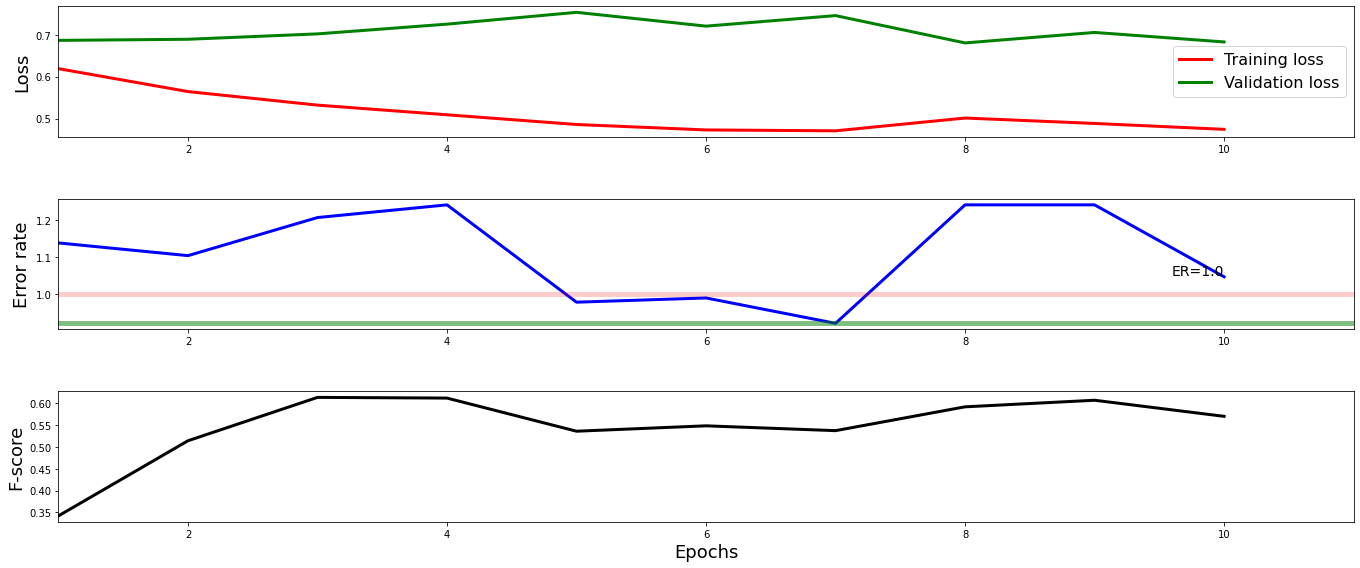

In [ ]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))

plt.subplot(3,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
#plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,2)
plt.plot(epochs, hist['val_er'], color='blue', linewidth=3, label='Validation Error rate')
plt.axhline(y=1, color='red', linestyle='-', linewidth=5, alpha=0.2)
plt.ylabel('Error rate', fontsize=18)
er_min_index = numpy.argmin(hist['val_er'])
plt.axhline(hist['val_er'][er_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5) #'o', markersize=10, color='red')
plt.annotate('Minimum achieved ER value', xy=(len(hist['loss']),hist['val_er'][er_min_index]-0.15), fontsize=14, ha='right')
plt.annotate('ER=1.0', xy=(len(hist['loss']),1+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
panel.get_xaxis().set_visible(True)

plt.subplot(3,1,3)
plt.plot(epochs, hist['val_f1'], color='black', linewidth=3, label='F-score')
plt.ylabel('F-score', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])
plt.tight_layout()
plt.show()

# Testing stage

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/crnn_gru_sed_weight/model_seds_direct_script_upto_10_epochs_new.h5') # Load model

## Going through all test material

In [ ]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_sed.csv'))

audio_folder_name = '/content/drive/MyDrive/5th_sem/Ee603_mlsp/Project/validation_data/validation_wavs'
for audio_filename in os.listdir(audio_folder_name):
    # Load features
    # features = get_feature_matrix(item.filename)
    # features_sequenced = data_sequencer.sequence(features).data
    # input_data = numpy.moveaxis(features_sequenced, 2, 0) # Rearrange axes => (sequence, feature vector, time)
    audio_path = os.path.join(audio_folder_name, audio_filename)
    features, hop_length_seconds = get_feature_matrix_script_features(audio_path)
    #features = features[:,:500]
    input_data = features.reshape(1, features.shape[0], features.shape[1])


    # Get network output
    item_probabilities_seq = model.predict(x=input_data)        # Get per frame probabilities in sequences (3D matrix)
    item_probabilities = numpy.vstack(item_probabilities_seq)   # Merge sequences together (2D matrix)

    # Event activity
    event_activity = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=item_probabilities,
        binarization_type='global_threshold',
        threshold=0.5
    )
    current_estimated = dcase_util.containers.MetaDataContainer()
    for event_id, event_label in enumerate(['speech', 'music']):
        # Convert active frames into segments and translate frame indices into timestamps
        event_segments = dcase_util.data.DecisionEncoder().find_contiguous_regions(
            activity_array=event_activity[:, event_id]
        ) * 0.03194888178

        # Form event items
        for event in event_segments:
            current_estimated.append(
                {
                    'filename': audio_filename,
                    'onset': event[0],
                    'offset': event[1],
                    'event_label': event_label
                }
            )
            
        # Merge events together from same class which are within 100ms
        current_estimated = current_estimated.process_events(minimum_event_gap=0.5)
        # Remove events which are < 100ms 
        current_estimated = current_estimated.process_events(minimum_event_length=0.5)
        
    # Store result into results container
    res += current_estimated
    
# Save results container
res.save().show(mode='print')

MetaDataContainer :: Class
Filename                            : /content/data/results_sed.csv 
Items                               : 34 
Unique
  Files                             : 12 
  Scene labels                      : 0 
  Event labels                      : 2 
  Tags                              : 0 
  Identifiers                       : 0 
  Source labels                     : 0 

Event statistics
  Event label             Count   Tot. Length   Avg. Length   
  --------------------   ------   -----------   -----------   
  music                      15         36.81          2.45   
  speech                     19         43.16          2.27   




# Evaluation

`sed_eval` toolbox is used to get Error rate and F-score for test set:

In [ ]:
res = dcase_util.containers.MetaDataContainer().load(filename=os.path.join(data_storage_path, 'results_sed.csv'))

## Preparing data for evaluation

Prepare reference data and estimated to have filenames in uniform format:

In [ ]:
reference_event_list = validation_meta
estimated_event_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_sed.csv')
).load()

for item_id, item in enumerate(estimated_event_list):
    estimated_event_list[item_id]['filename'] = item.filename.split('.')[0]    

In [ ]:
# Initialize evaluator with list of event labels to be evaluated and segment length
evaluator = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=['speech', 'music'], 
    time_resolution=0.2                    # 1 second segments
)
# Loop file by file and accumulate intermediate statistics
for filename in reference_event_list.unique_files:
    evaluator.evaluate(
        reference_event_list=reference_event_list.filter(filename=filename),
        estimated_event_list=estimated_event_list.filter(filename=filename)
    ) 
metrics = evaluator.results_overall_metrics()

## Metric values

In [ ]:
log.table(
    column_headers=['Metric', 'Value'],
    cell_data=[
        [
          '<strong>F-score</strong>',
          'Precision',
          'Recall',
          '<strong>Error rate</strong>',
            'Substitutions',
            'Deletions',
            'Insertions'
        ],
        [
            metrics['f_measure']['f_measure']*100.0,
            metrics['f_measure']['precision']*100.0,
            metrics['f_measure']['recall']*100.0,
            metrics['error_rate']['error_rate'],
            metrics['error_rate']['substitution_rate'],
            metrics['error_rate']['deletion_rate'],
            metrics['error_rate']['insertion_rate'],
        ]
    ],
    row_separators=[3],
    scaling=130
)

Metric,Value
F-score,1.46
Precision,49.45
Recall,0.74
Error rate,1.00
Substitutions,0.00
Deletions,0.99
Insertions,0.00


## Class-wise metrics

In [ ]:
class_metrics = evaluator.results_class_wise_metrics()
Nref = []
Nsys = []
Fscore=[]
for event_label in list(class_metrics.keys()):
    Nref.append(class_metrics[event_label]['count']['Nref'])
    Nsys.append(class_metrics[event_label]['count']['Nsys'])
    Fscore.append(class_metrics[event_label]['f_measure']['f_measure']*100.0)
log.table(
    column_headers=['Event', 'Nref', 'Nsys', 'Fscore'],
    cell_data=[
        list(class_metrics.keys()),Nref,Nsys,Fscore
    ],
    column_types=['str25', 'int', 'int', 'float2'],
    column_separators=[0,2],
    scaling=130
)

Event,Nref,Nsys,Fscore
speech,15750,286,1.40
music,14250,237,1.10


Output directly from `sed_eval` evaluator:

In [ ]:
print(evaluator)    

Segment based metrics
  Evaluated length                  : 116.19 sec
  Evaluated files                   : 12 
  Segment length                    : 200.00 ms

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 41.85 %
    Precision                       : 32.61 %
    Recall                          : 58.40 %
  Error rate
    Error rate (ER)                 : 1.39 
    Substitution rate               : 0.24 
    Deletion rate                   : 0.18 
    Insertion rate                  : 0.97 
  Accuracy
    Sensitivity                     : 58.40 %
    Specificity                     : 40.96 %
    Balanced accuracy               : 49.68 %
    Accuracy                        : 46.69 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 41.59 %
    Precision                       : 33.30 %
    Recall                          : 59.44 %
  Error rate
    Error rate (ER)                 : 1.64 
    Deletion rate